In [2]:
#!pip install xgboost pandas scikit-learn matplotlib tqdm --quiet

In [3]:
#!pip install optuna --quiet

# Predicción de Regalías por Artista con XGBoost
### Tesis de Maestría en Ciencia de Datos
Este notebook aplica un modelo XGBoost multivariado para predecir las regalías mensuales por artista.
Se evalúa el desempeño mediante métricas de error y se exportan las predicciones para su uso en Power BI.

In [4]:
import pandas as pd

#file_id = '14dqOhZOxoLZVI0vtsf03g_VSJsm05Me_' #version 1
file_id = '19rKtmLEbIyBd0b5HUxBzXxJb92YegK8W' #version 2
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url)
df['fecha'] = pd.to_datetime(df['fecha'], format='%m/%d/%Y')
df.head()

,songstats_artist_id,fecha,royalties,instagram_followers,twitter_followers,track_release,sentiment,seguidores_menciones,cant_posteos,cant_comentarios,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_seguidores_menciones_3m,month
0,436lvfnz,2022-07-01,94291.905,5250688,643908,1,0.649123,26326461,3,57,94291.90500,0.00000,0,0,1,0.649123,26326461,7
1,436lvfnz,2022-08-01,90967.300,5283706,647332,0,0.493088,26326461,7,217,92629.60250,23347.25170,3424,33018,1,0.571105,52652922,8
2,436lvfnz,2022-09-01,96849.325,5316966,648728,1,0.703297,0,5,91,94036.17667,33139.07363,1396,33260,2,0.615169,52652922,9
3,436lvfnz,2022-10-01,94944.180,5346661,649390,0,0.548611,50734,5,144,94263.17750,41478.03735,662,29695,2,0.581665,26377195,10
4,436lvfnz,2022-11-01,93308.900,5403544,649732,1,0.557554,26326461,10,278,94072.32200,58780.37927,342,56883,3,0.603154,26377195,11


In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from tqdm.notebook import tqdm

results = []
predictions_output = []

for artist_id, group in tqdm(df.groupby("songstats_artist_id")):
    group = group.sort_values("fecha")

    if len(group) < 10:
        continue

    X = group[["instagram_followers", "twitter_followers", "track_release", "sentiment", "seguidores_menciones", "cant_posteos", "cant_comentarios", "mean_royalties_6m", "std_instagram_followers_6m", "growth_twitter_followers", "growth_instagram_followers", "sum_track_releases_6m", "mean_sentiment_3m", "sum_seguidores_menciones_3m", "month"]]
    y = group["royalties"]
    fechas = group["fecha"]

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    fechas_train, fechas_test = fechas[:train_size], fechas[train_size:]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)

    mse = mean_squared_error(y_test, forecast)
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, forecast)

    results.append({
        "Artist_ID": artist_id,
        "Modelo": "XGBoost",
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

    for f, real, pred in zip(fechas_test, y_test, forecast):
        predictions_output.append({
            "songstats_artist_id": artist_id,
            "fecha": f,
            "royalties_real": real,
            "royalties_pred": pred,
            "modelo": "XGBoost"
        })

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
df_results = pd.DataFrame(results)
df_results.to_csv("xgboost_metrics_por_artista.csv", index=False)

df_preds = pd.DataFrame(predictions_output)
df_preds.to_csv("xgboost_predicciones_para_powerbi.csv", index=False)
df_results.head()

,Artist_ID,Modelo,MSE,MAE,RMSE,MAPE
0,436lvfnz,XGBoost,1.325004e+09,33822.949955,36400.602766,0.207862
1,5jwhbt0o,XGBoost,2.602733e+07,3250.645285,5101.698870,0.281256
2,5t4iv6o3,XGBoost,2.205998e+09,45620.152857,46968.057323,0.134839
3,65m1vtnc,XGBoost,1.162065e+10,92208.587222,107799.106415,0.130734
4,67gc5xm9,XGBoost,3.274677e+09,49809.278056,57224.791576,0.124911


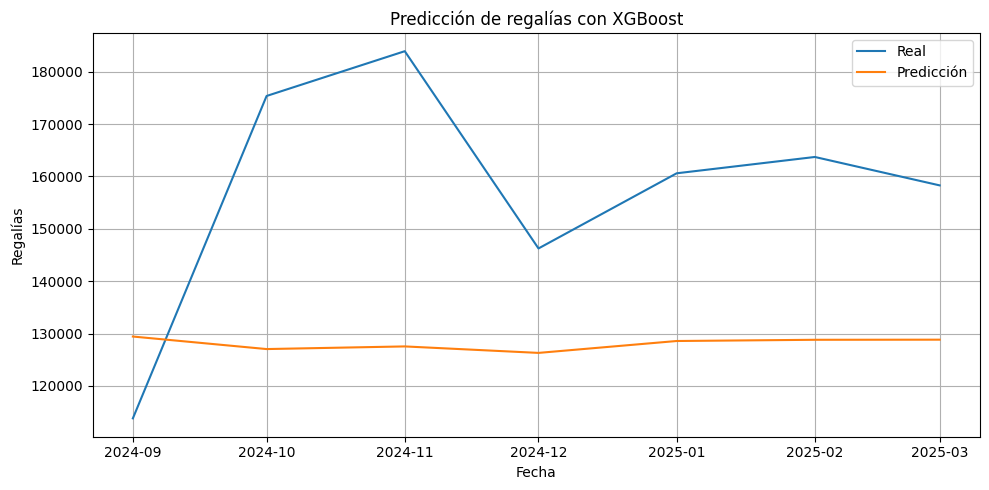

In [7]:
import matplotlib.pyplot as plt

ejemplo = df_preds[df_preds["songstats_artist_id"] == df_preds["songstats_artist_id"].unique()[0]]
plt.figure(figsize=(10,5))
plt.plot(ejemplo["fecha"], ejemplo["royalties_real"], label="Real")
plt.plot(ejemplo["fecha"], ejemplo["royalties_pred"], label="Predicción")
plt.title("Predicción de regalías con XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Regalías")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Forecast

XGBoost no predice naturalmente en el tiempo futuro como Prophet o SARIMAX.
Se suele preparar de dos formas:

* Rolling Prediction: predecir 1 mes, agregarlo al dataset, volver a predecir el siguiente mes, etc.
* Batch Prediction: si tenés todas las variables independientes del futuro (por ejemplo, mes, año, sentimiento futuro, lanzamientos futuros), podrías predecir todo de golpe.
(pero normalmente no tenemos eso en real forecast).

En nuestro caso, lo que corresponde es hacer rolling:
1. Predecimos el primer mes usando el último dato disponible.
2. Ese primer forecast lo usamos como input para predecir el segundo mes.
3. Así sucesivamente hasta llegar a los 6 meses.

In [8]:
def forecast_xgboost_por_artista(df, artist_id, steps=6):
    """
    Entrena XGBoost por artista y realiza forecast rolling de 6 meses.

    Parámetros:
    - df: DataFrame general
    - artist_id: ID del artista
    - steps: cantidad de meses a predecir

    Retorna:
    - forecast_df: DataFrame con predicciones
    - fig: gráfico
    """
    # Filtrar datos
    df_artista = df[df['songstats_artist_id'] == artist_id].copy()
    df_artista = df_artista.sort_values('fecha')

    # Asegurarse de que las fechas estén bien
    df_artista['fecha'] = pd.to_datetime(df_artista['fecha'])
    df_artista = df_artista.set_index('fecha').asfreq('MS')

    # Crear variables de fecha (month, year)
    df_artista['month'] = df_artista.index.month
    df_artista['year'] = df_artista.index.year

    # Variables independientes (features) y target
    X = df_artista[['month', 'year']]
    y = df_artista['royalties']

    # Entrenar modelo
    modelo = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    modelo.fit(X, y)

    # Forecast rolling
    forecasts = []
    last_date = df_artista.index[-1]
    last_month = last_date.month
    last_year = last_date.year

    for i in range(steps):
        # Calcular siguiente mes y año
        if last_month == 12:
            next_month = 1
            next_year = last_year + 1
        else:
            next_month = last_month + 1
            next_year = last_year

        # Crear input
        X_pred = pd.DataFrame({'month': [next_month], 'year': [next_year]})

        # Predecir
        y_pred = modelo.predict(X_pred)[0]

        # Guardar predicción
        pred_date = last_date + pd.DateOffset(months=1)
        forecasts.append({'songstats_artist_id': artist_id,
                          'fecha_prediccion': pred_date,
                          'royalties_forecast': y_pred})

        # Actualizar "última fecha"
        last_date = pred_date
        last_month = last_date.month
        last_year = last_date.year

        # (Opcional) podríamos agregar el predicho al training para simular mejor, pero ahora hacemos simple.

    forecast_df = pd.DataFrame(forecasts)

    # Gráfico
    fig, ax = plt.subplots(figsize=(10, 5))
    y.plot(ax=ax, label='Histórico')
    forecast_df.set_index('fecha_prediccion')['royalties_forecast'].plot(ax=ax, label='Forecast', color='orange')
    ax.set_title(f'Forecast XGBoost - Artista {artist_id}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Royalties')
    ax.legend()
    plt.tight_layout()
    plt.close(fig)

    return forecast_df, fig


In [9]:
# Lista de artistas
lista_artistas = df['songstats_artist_id'].unique()

# Almacenar resultados
lista_forecasts = []
lista_figuras = []

# Loop
for artist_id in lista_artistas:
    forecast_df, figura = forecast_xgboost_por_artista(df, artist_id, steps=6)
    lista_forecasts.append(forecast_df)
    lista_figuras.append((artist_id, figura))

# Consolidar
df_forecasts_consolidado = pd.concat(lista_forecasts, ignore_index=True)


Gráfico de forecast para el artista 436lvfnz


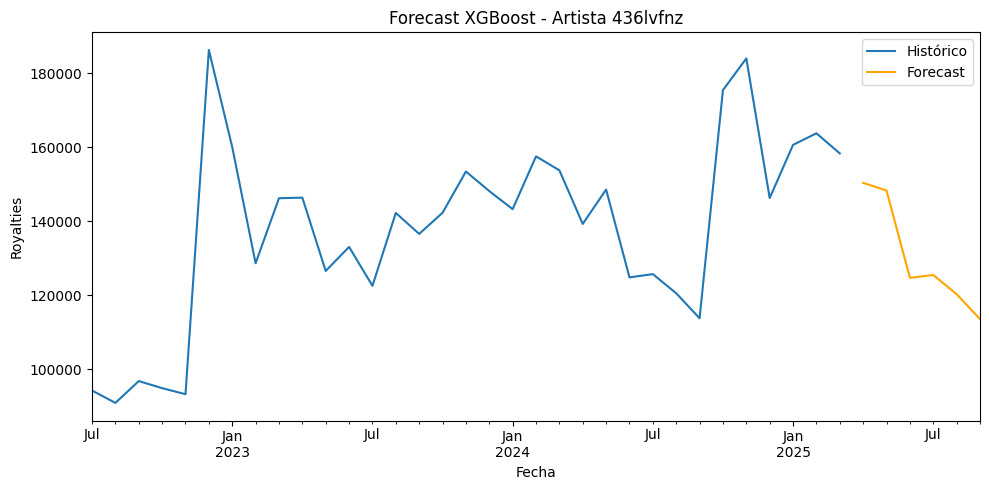

Gráfico de forecast para el artista 5jwhbt0o


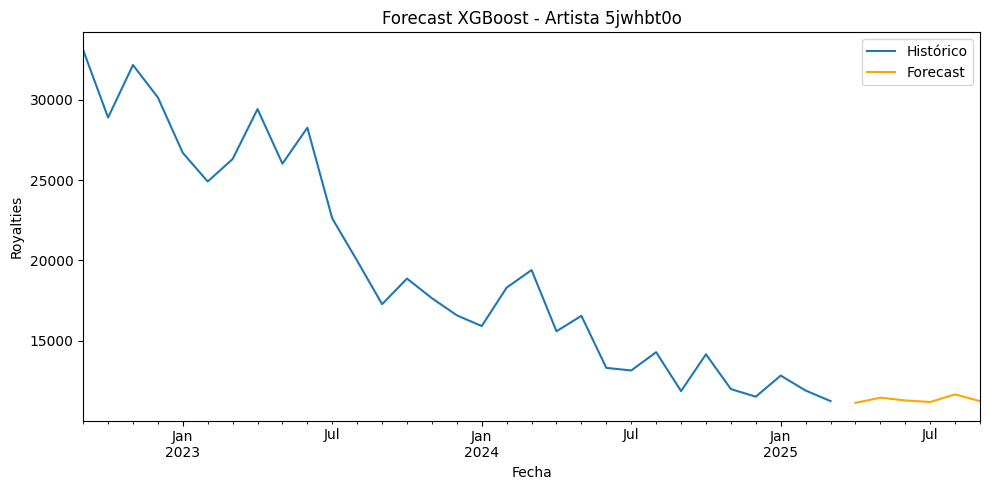

Gráfico de forecast para el artista 5t4iv6o3


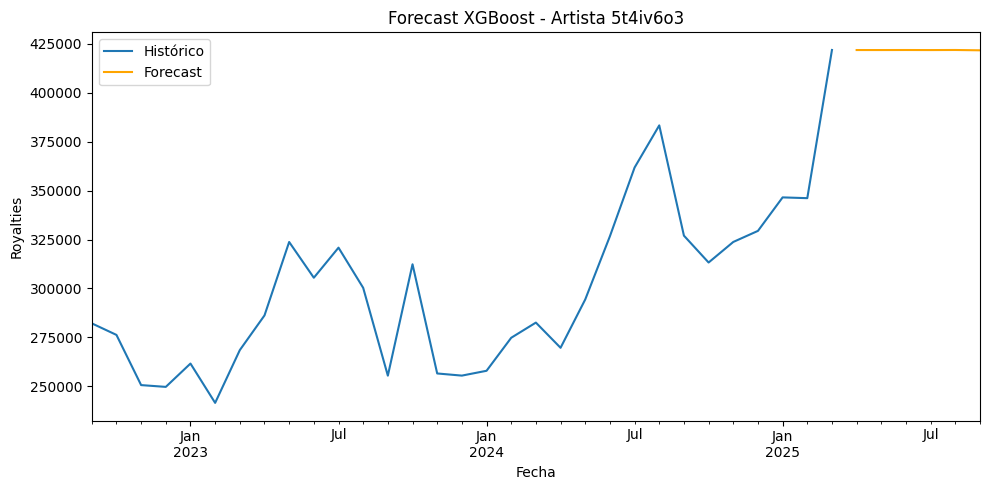

Gráfico de forecast para el artista 65m1vtnc


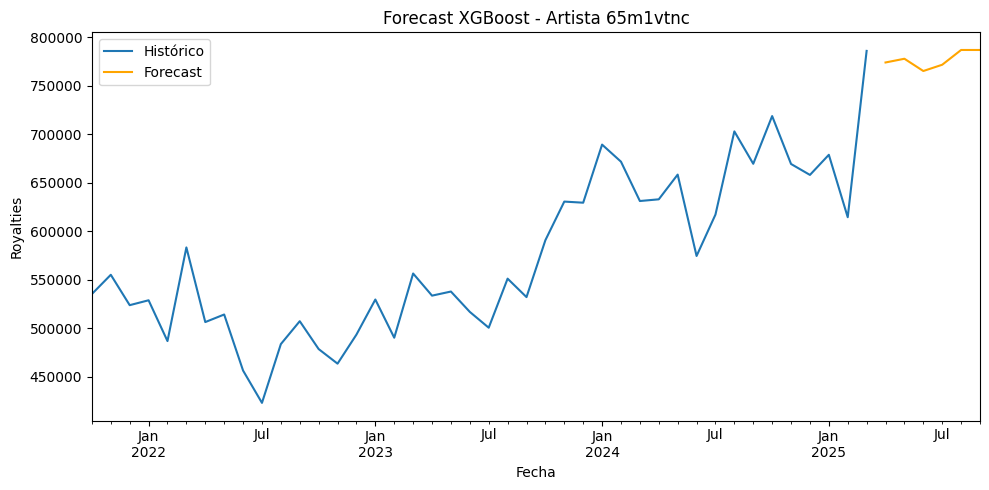

Gráfico de forecast para el artista 67gc5xm9


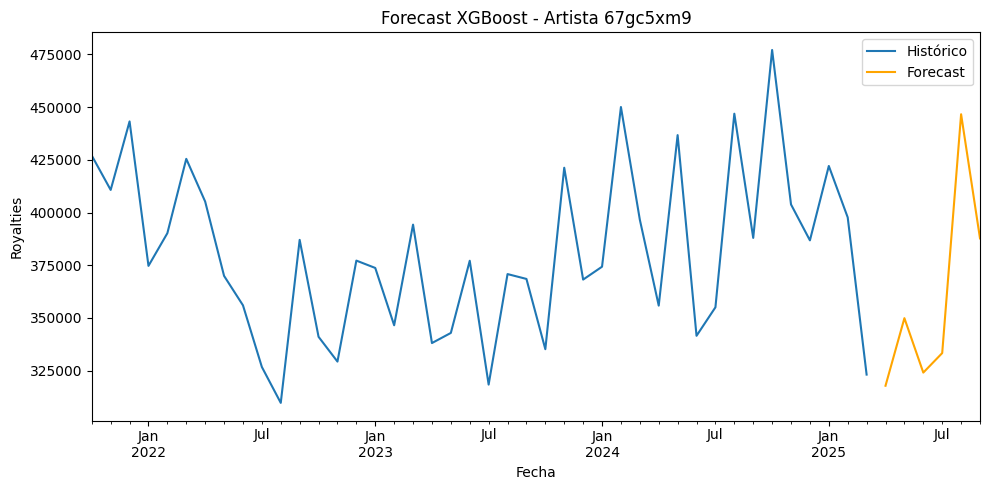

Gráfico de forecast para el artista 6ygz70qs


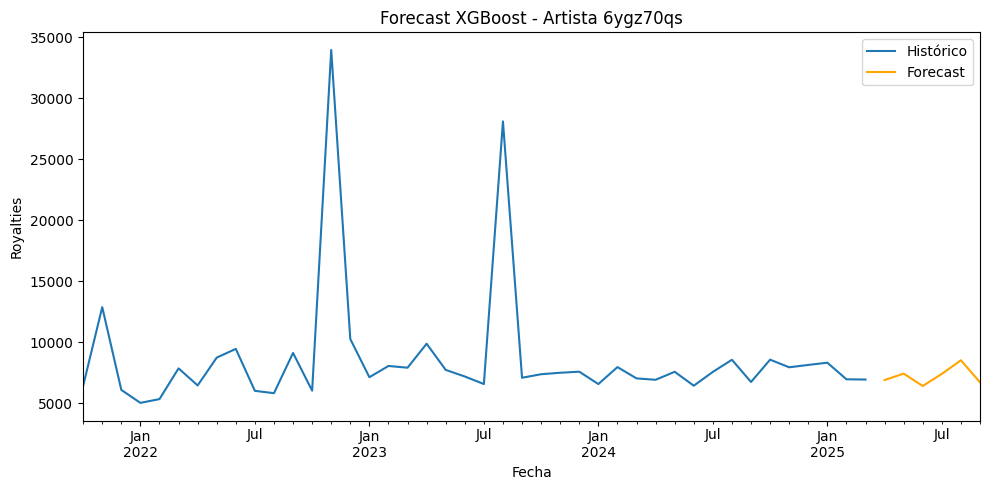

Gráfico de forecast para el artista al0gcvtm


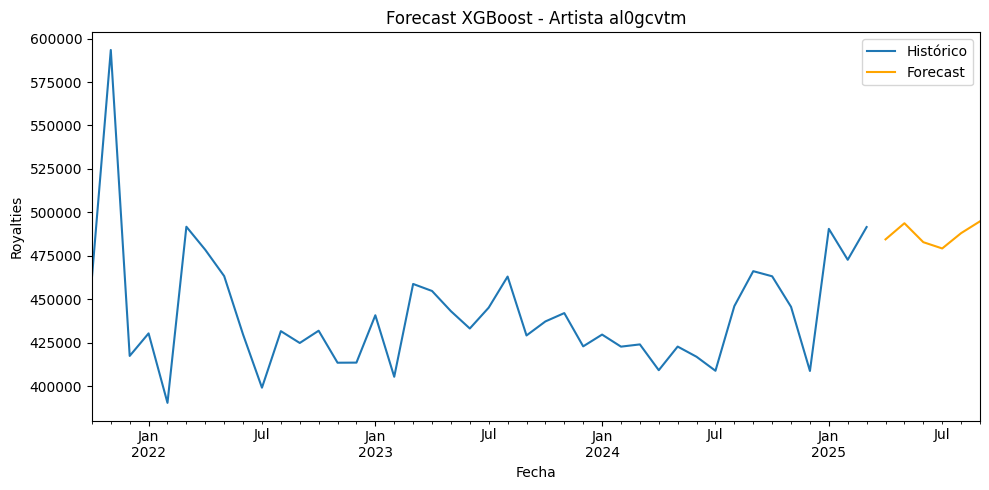

Gráfico de forecast para el artista awrkf92m


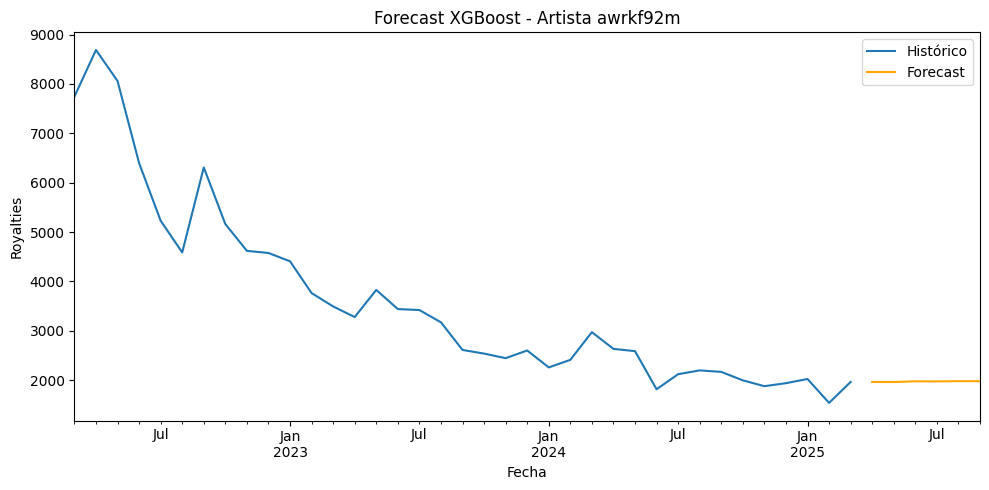

Gráfico de forecast para el artista bpgx7194


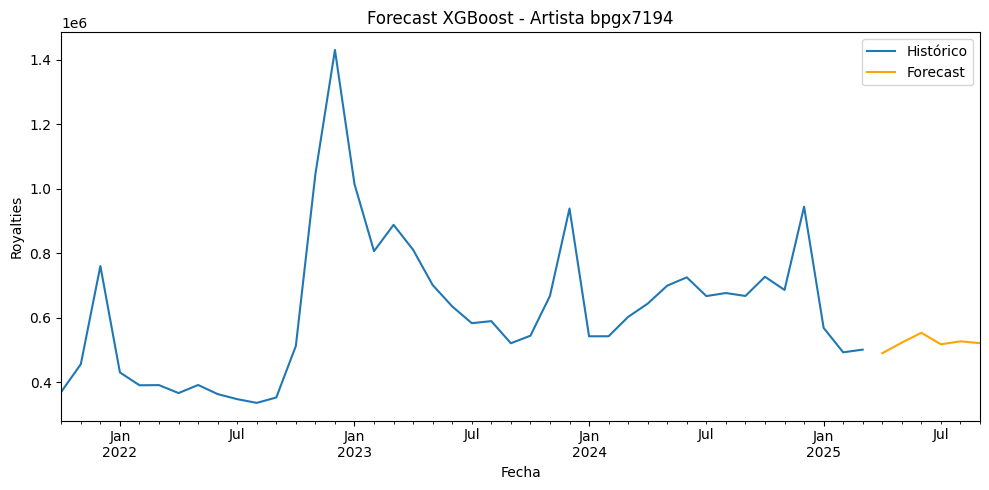

Gráfico de forecast para el artista hfiatnv8


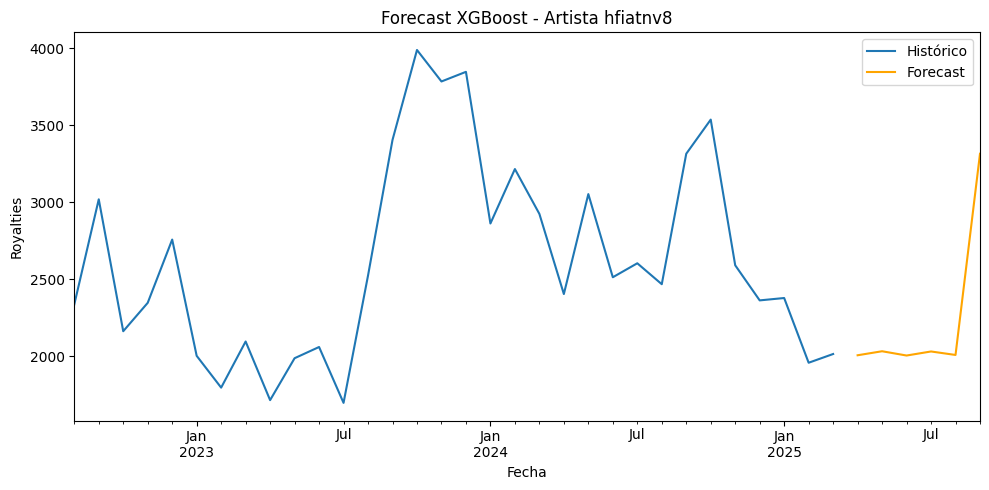

Gráfico de forecast para el artista jla6nu3p


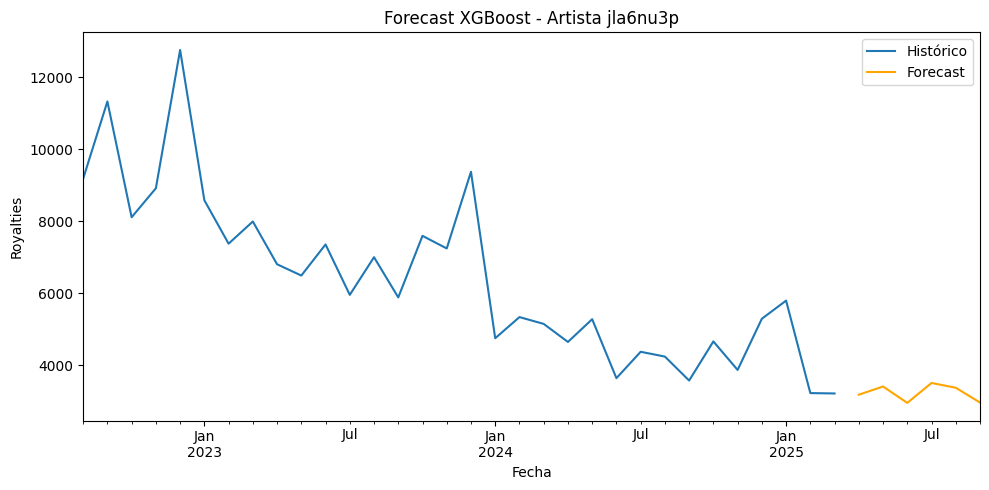

Gráfico de forecast para el artista k74pw1av


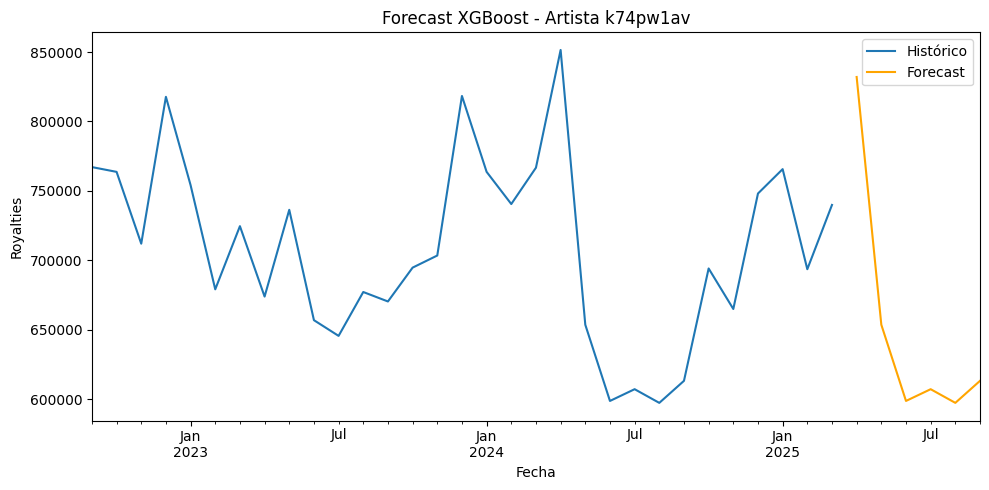

Gráfico de forecast para el artista kcw3uapo


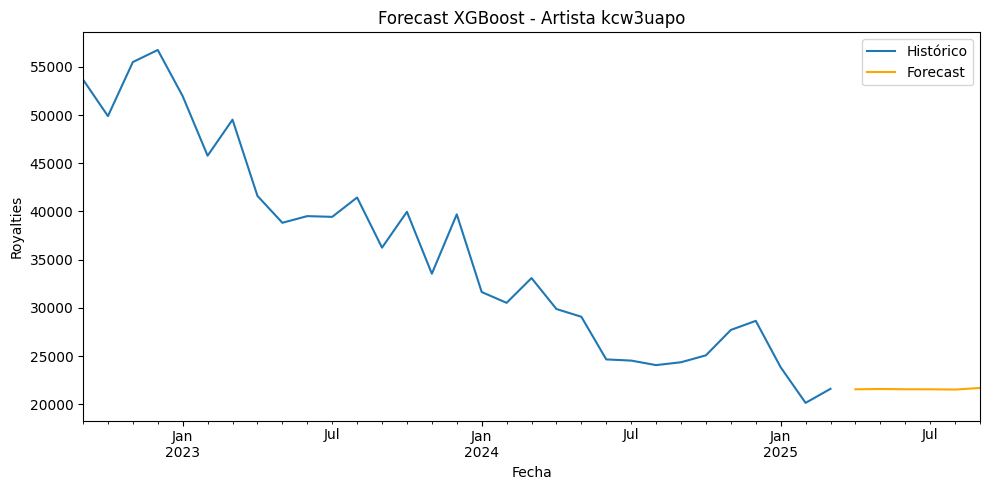

Gráfico de forecast para el artista pymr5w10


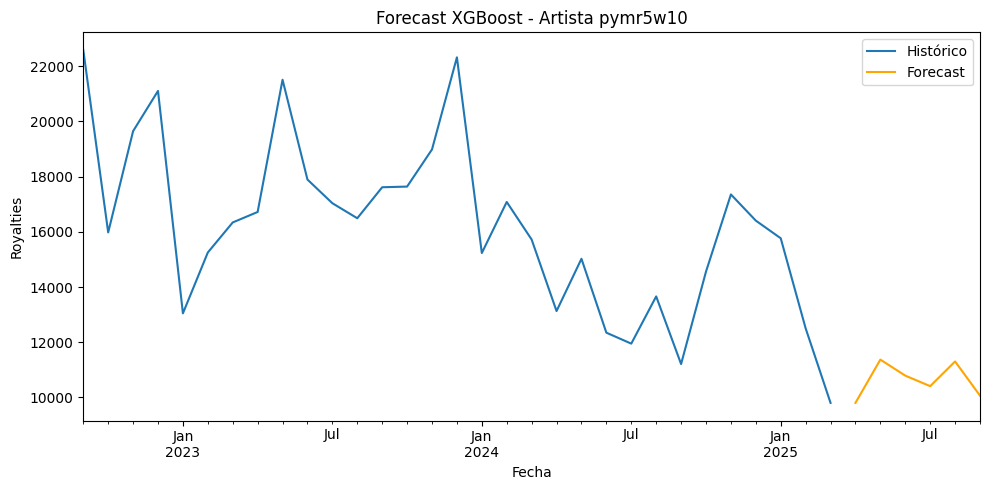

Gráfico de forecast para el artista r976ytqo


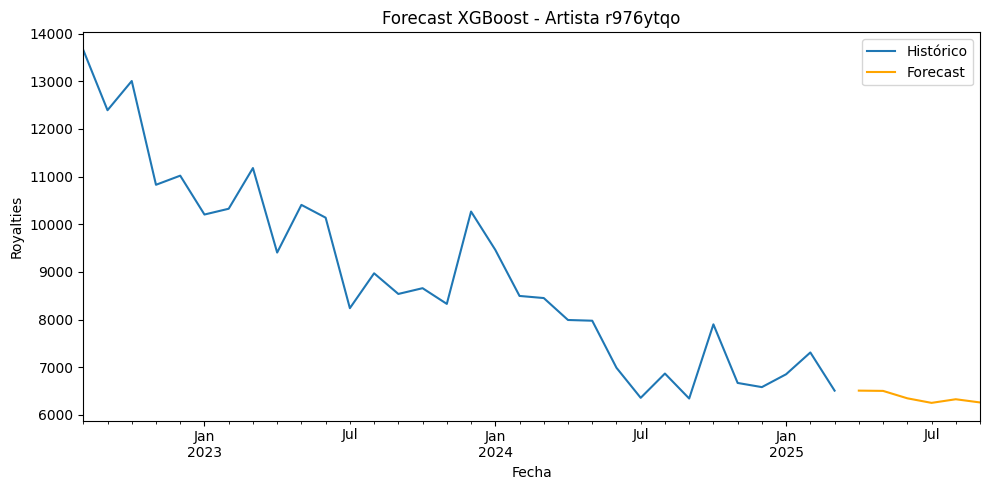

In [10]:
# Mostrar gráficos
for artist_id, figura in lista_figuras:
    print(f"Gráfico de forecast para el artista {artist_id}")
    display(figura)


In [11]:
# Guardar el resultado
df_forecasts_consolidado.to_csv('xgboost_forecast_royalties_artistas.csv', index=False)
